# 2. Preprocessing

Welcome to the second part of our tutorial.
This notebook will teach you how to preprocess a sensor based Human Activity Recognition dataset.

Data preprocessing is an essential part of any Deep Learning project. In this part you 
To be able to choose the correct preprocessing steps, first we need to get to know our data. However, this topic has already been dealt with in Chapter 1.

In the first part we will work on the same subset, that we already had been working with in Chapter 1.
So let's start by reading in the dataset.

Welcome to the second notebook of our six part series part of our tutorial on Deep Learning for Human Activity Recognition. Within the last notebook you learned:

- How do I use Google Colab and Jupyter Notebooks? 
- How do I load a dataset using pandas?
- How do I analyze the labeling? How do I plot sample activity data?
- What are sample, more detailled analysis that one can apply on a HAR dataset?

This notebook will teach you everything you need to know about preprocessing. Sensor datasets in their raw form are (usually) very messy. This notebook will teach you which preprocessing steps can or should be executed on a dataset, in order to train a working classifer, i.e. our neural network architecture, which we will define in later notebooks. 

After completing this notebook you will be answer the following questions:
- What data cleaning steps usually need to be performed on a raw sensor dataset?
- What importance does sensor orientation have? How do we match the sensor orientation of different sensors?
- How and why do we perform normalization?
- What is a sliding window? How do we apply it?

## 2.1. Important Remarks

If you are accessing this tutorial via [Google Colab](https://colab.research.google.com/github/mariusbock/dl-for-har/blob/main/tutorial_notebooks/training.ipynb), first make sure to use Google Colab in English. This will help us to better assist you with issues that might arise during the tutorial. There are two ways to change the default language if it isn't English already:
1. On Google Colab, go to `Help` -> `View in English` 
2. Change the default language of your browser to `English`.

To also ease the communication when communicating errors, enable line numbers within the settings of Colab.

1. On Google Colab, go to `Tools` -> `Settings` -> `Editor` -> `Show line numbers`

In general, we strongly advise you to use Google Colab as it provides you with a working Python distribution as well as free GPU resources. To make Colab use GPUs, you need to change the current notebooks runtime type via:

- `Runtime` -> `Change runtime type` -> `Dropdown` -> `GPU` -> `Save`

**Hint:** you can auto-complete code in Colab via `ctrl` + `spacebar`

For the live tutorial, we require all participants to use Colab. If you decide to rerun the tutorial at later points and rather want to have it run locally on your machine, feel free to clone our [GitHub repository](https://github.com/mariusbock/dl-for-har).

To get started with this notebook, you need to first run the code cell below. Please set `use_colab` to be `True` if you are accessing this notebook via Colab. If not, please set it to `False`. This code cell will make sure that imports from our GitHub repository will work.

In [1]:
import os, sys

use_colab = True

module_path = os.path.abspath(os.path.join('..'))

if use_colab:
    # move to content directory and remove directory for a clean start 
    %cd /content/         
    %rm -rf dl-for-har
    # clone package repository (will throw error if already cloned)
    !git clone https://github.com/mariusbock/dl-for-har.git
    # navigate to dl-for-har directory
    %cd dl-for-har/       
else:
    os.chdir(module_path)
    
# this statement is needed so that we can use the methods of the DL-ARC pipeline
if module_path not in sys.path:
    sys.path.append(module_path)

[Errno 2] No such file or directory: '/content/'
/Users/ahoelzemann/Documents/git/dl-for-har/tutorial_notebooks
Cloning into 'dl-for-har'...
remote: Enumerating objects: 1090, done.
remote: Counting objects: 100% (1090/1090), done.
remote: Compressing objects: 100% (743/743), done.
remote: Total 1090 (delta 549), reused 850 (delta 337), pack-reused 0
Receiving objects: 100% (1090/1090), 34.51 MiB | 7.96 MiB/s, done.
Resolving deltas: 100% (549/549), done.
Updating files: 100% (262/262), done.
/Users/ahoelzemann/Documents/git/dl-for-har/tutorial_notebooks/dl-for-har


## 2.2. Reading the dataset

Before getting into the actual content of this notebook, we need to load the data again. Instead of using the same way as previously and loading the dataset we will use a predefined method of the DL-ARC feature stack called `load_dataset()`. Since the method returns [numpy](https://numpy.org/) arrays we also need to adjust our workflow from now on to index arrays according to [numpy](https://numpy.org/) syntax. If you want to familiarise yourself how to index check out this [webpage](https://numpy.org/doc/stable/reference/arrays.indexing.html).

### Task 1: Loading the data

1. Load the `rwhar_3sbjs` data using the load_dataset function. The function is already imported for you. (`lines 8-9`)
2. The method returns additional attributes. Have a look at them. You can also print them to see what values they have.

In [2]:
import numpy as np
import warnings
warnings.filterwarnings("ignore")

from data_processing.preprocess_data import load_dataset


# load the dataset using the load_dataset() function; pass the method the name of the dataset as a string
X, y, num_classes, class_names, sampling_rate, has_null = load_dataset('rwhar_3sbjs')

# since the method returns features and labels separately, we need to concat them
# since y is 
data = np.concatenate((X, y[:, None]), axis=1)

print('\nShape of the dataset:')
print(data.shape)
print(data)

Processing dataset files ...
Full dataset with size: | X (659260, 4) | y (659260,) | 
 ..from file data/rwhar_3sbjs_data.csv

Shape of the dataset:
(659260, 5)
[[ 0.          0.37828386 10.168175    0.8475474   1.        ]
 [ 0.          0.38367084 10.172364    0.8499416   1.        ]
 [ 0.          0.37229836 10.181941    0.8595184   1.        ]
 ...
 [ 2.         -1.0540473  10.114903    0.3716998   5.        ]
 [ 2.         -1.0582372  10.109517    0.35075054  5.        ]
 [ 2.         -1.0726024  10.138845    0.350152    5.        ]]


## 2.3. Cleaning


There can be several reasons why we need to clean up a dataset. For example, it is common that datasets has missing values.
These values need to be interpolated. PAMAP2 is one of the datasets that is used very frequently in scientific publications, which contains missing values.

An example to clean data from missing values, especially NaN-values, can be found in the file **data_precessing.preprocess.data.py**.

Also it can be beneficial to clean a dataset from noisy data or from outliers.
But be careful with cleaning the data from noise or outlier, since it only is recommendable if the noise/outlier is not from any importance for the use case of your model.


In [3]:
import random
from data_processing.preprocess_data import replaceNaNValues
data_with_nan = data.copy()

for i in range(0, 10):
    fill_index = random.randint(1, 20)
    # data_with_nan = np.insert(data_with_nan, fill_index, [np.nan, np.nan, np.nan, np.nan, np.nan])
    data_with_nan[fill_index] = [np.nan, np.nan, np.nan, np.nan, np.nan]

print(data_with_nan[:20])

[[ 0.          0.37828386 10.168175    0.8475474   1.        ]
 [ 0.          0.38367084 10.172364    0.8499416   1.        ]
 [ 0.          0.37229836 10.181941    0.8595184   1.        ]
 [ 0.          0.3429694  10.170568    0.8343793   1.        ]
 [ 0.          0.3196259  10.159795    0.81881696  1.        ]
 [        nan         nan         nan         nan         nan]
 [ 0.          0.3585317  10.181941    0.82719666  1.        ]
 [        nan         nan         nan         nan         nan]
 [ 0.          0.3812766  10.16578     0.8158242   1.        ]
 [        nan         nan         nan         nan         nan]
 [        nan         nan         nan         nan         nan]
 [ 0.          0.38726214 10.19092     0.8098387   1.        ]
 [ 0.          0.36391866 10.156802    0.79846627  1.        ]
 [        nan         nan         nan         nan         nan]
 [        nan         nan         nan         nan         nan]
 [ 0.          0.40940848 10.19092     0.82779527  1.  

In [7]:
participant_interpolated = replaceNaNValues(data_with_nan[:,0], 'int')
acc_x_interpolated = replaceNaNValues(data_with_nan[:,1])
acc_y_interpolated = replaceNaNValues(data_with_nan[:,2])
acc_z_interpolated = replaceNaNValues(data_with_nan[:,3])
label_interpolated = replaceNaNValues(data_with_nan[:,4], 'int')

data_interpolated = np.array([participant_interpolated, acc_x_interpolated, acc_y_interpolated, acc_z_interpolated, label_interpolated]).T
print(data_interpolated[:20])

[[ 0.          0.37828386 10.168175    0.8475474   1.        ]
 [ 0.          0.38367084 10.172364    0.8499416   1.        ]
 [ 0.          0.37229836 10.181941    0.8595184   1.        ]
 [ 0.          0.3429694  10.170568    0.8343793   1.        ]
 [ 0.          0.3196259  10.159795    0.81881696  1.        ]
 [ 0.          0.3390788  10.170868    0.8230068   1.        ]
 [ 0.          0.3585317  10.181941    0.82719666  1.        ]
 [ 0.          0.36990416 10.173861    0.82151043  1.        ]
 [ 0.          0.3812766  10.16578     0.8158242   1.        ]
 [ 0.          0.38426936 10.17835     0.81283146  1.        ]
 [ 0.          0.38576573 10.184635    0.8113351   1.        ]
 [ 0.          0.38726214 10.19092     0.8098387   1.        ]
 [ 0.          0.36391866 10.156802    0.79846627  1.        ]
 [ 0.          0.38666356 10.173861    0.81313074  1.        ]
 [ 0.          0.398036   10.18239     0.820463    1.        ]
 [ 0.          0.40940848 10.19092     0.82779527  1.  

## 2.4. Resampling

Resampling is necessary if we work with data from sensors that recorded with different sampling rates.
Resampling can either be done by up- or downsample the data.

An example for a function that either up- or downsamples time series data, can be found as well in our collection of preprocessing functions: **data_precessing.preprocess.data.py**.

## 2.5. Normalizing

Normalizing is in an important part in the preprocessing chain, but can also the reason for many mistakes.
Therefore it is important to choose the correct strategy to normalize your dataset.
Therefore, we will dig deeper into this topic at this point of our tutorial.

### 2.5.1 How to normalize?

The best ways to normalize a dataset is either sensor- or axis-wise. However, there certain pitfalls a programmer can fall into.
Normalizing sensor-wise means that whenever we have a dataset that contains data from different types of sensors, like e.g accelerometer and
magnetometer data, these data should never have been normalized together.


![](https://github.com/mariusbock/dl-for-har/blob/main/images/pamap2_values_example.png?raw=true)

This image shows how our datasets are often organized. We have a 2D matrix that contains the data from different sensor axes and sensor types.
Whenever you start working with deep learning, you normally start with a tutorial that works with image data. For image data it is fine to normalize your
data all at once, since all input data share the same boundaries (0-255 when working with RGB).
However, when it comes to sensor data this rule doesn't apply. Accelerometer, Gyroscopes, Magnetometer or any other sensor do not share
the same boundaries. Furthermore, the boundaries also depend on the sensitivity used while recording the data.

So be sure to organize your data correctly before you start normalizing them.

Another reason why we want to normalize is, that we would like to give the same importance to every input feature.

The numerical values of magnetometer measurements are much higher than accelerometer values. Since normalizing both sensor data together, will
keep this imbalance, we can break this up by normalizing data sensor- or even axis-wise.

However, data from one sensor or one axis should be kept together, and not be separated either user- or activity-wise before normalization. Otherwise,
the data will be distorted.

To illustrate the problem, let's look at the following code.

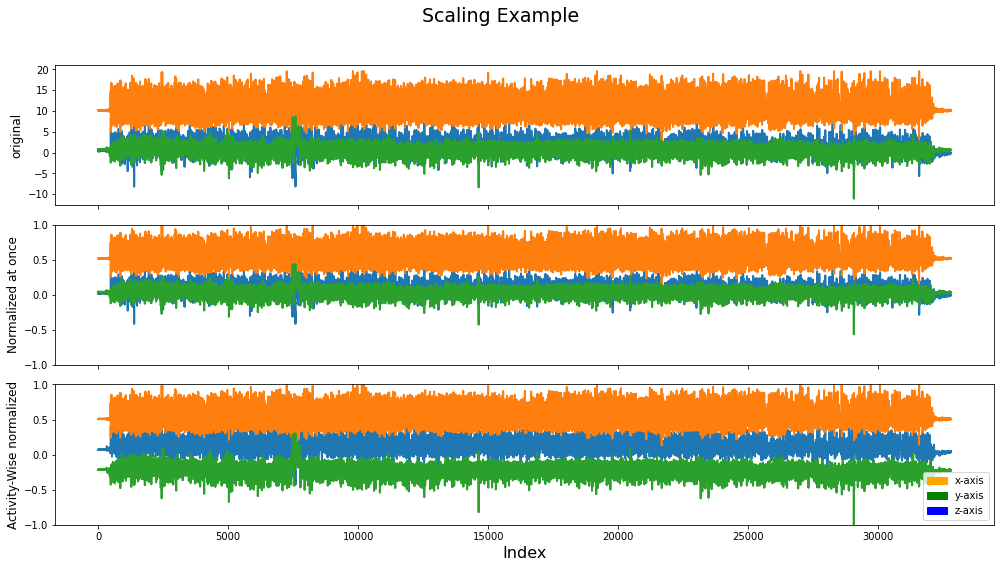

In [5]:
from data_processing.plotting import plot_imu_data
from sklearn.preprocessing import MinMaxScaler
import pandas as pd

scaler = MinMaxScaler(feature_range=[-1,1])
data_activity_wise = {}
data_activity_wise_scaled = []
all_activites = pd.unique(pd.Series(data[:, -1]))

for activity in all_activites:
    data_activity_wise[activity] = data[data[:, -1] == activity]

for activity, activity_data in data_activity_wise.items():
    data_activity_wise_scaled.append(scaler.fit_transform(activity_data[:, 1:4]))

scaled_data = scaler.fit_transform(data[:, 1:4])
data_scaled_at_once = np.concatenate((scaled_data, data[:, -1][:, None]), axis=1)[:32800]
data_activity_wise = np.concatenate(data_activity_wise_scaled)[:32800]

plot_imu_data(data[:, 1:4][:32800], data_scaled_at_once[:, 0:3], data_activity_wise, "Scaling Example")

## 2.6. Jumping/Sliding Window


In order to be able to feed our neural network with data, we need to organize it into smaller chunks.
Something that is more similar to the size of an image.
Therefore we apply a jumping/sliding window alogorithm with which we are able to split our time series data into chunks that our input layer can work with.

As already described in the slides, the algorithm has a parameter that describes how much of the data of each window should overlap with the window before. This is often
useful when we want to be sure that no transition from one activity to another is lost. 

### Task 2: Applying different sliding windows

1. The RWHAR dataset has a sampling rate of 50 Hz. Using the function below, apply a sliding window on top of RWHAR dataset whose windows are 2 seconds long. Set the overlap ratio to be 0%. What are the dimensions of the resulting dataset? (`lines 34-38`)
2. Change the overlap ratio of the slding window to 25%. What differences can you see and what do you think you need to be aware of when using an `overlap_ratio`? (`lines 40-43`)

In [6]:
def sliding_window_samples(data, samples_per_window, overlap_ratio):
    """
    Return a sliding window measured in number of samples over a data array.

    :param data: input array, can be numpy or pandas dataframe
    :param samples_per_window: window length as number of samples
    :param overlap_ratio: overlap is meant as percentage and should be an integer value
    :return: tuple of windows and indices
    """
    windows = []
    indices = []
    curr = 0
    win_len = int(samples_per_window)
    if overlap_ratio is not None:
        overlapping_elements = int((overlap_ratio / 100) * (win_len))
        if overlapping_elements >= win_len:
            print('Number of overlapping elements exceeds window size.')
            return
    while curr < len(data) - win_len:
        windows.append(data[curr:curr + win_len])
        indices.append([curr, curr + win_len])
        curr = curr + win_len - overlapping_elements
    try:
        result_windows = np.array(windows)
        result_indices = np.array(indices)
    except:
        result_windows = np.empty(shape=(len(windows), win_len, data.shape[1]), dtype=object)
        result_indices = np.array(indices)
        for i in range(0, len(windows)):
            result_windows[i] = windows[i]
            result_indices[i] = indices[i]
    return result_windows, result_indices

# apply the sliding_window_samples() function on top of the data
# samples_per_window shall be equivalent to two seconds; overlap_ratio shall be 0%
print("Shape of the windowed dataset (2 seconds with 0% overlap):")
windowed_data, _ = sliding_window_samples(data, 100, 0)
print(windowed_data.shape)

# change the overlap_ratio shall to be 25%; What do you need to be aware of?
windowed_data, _ = sliding_window_samples(data, 100, 25)
print("\nShape of the windowed dataset (2 seconds with 25% overlap):")
print(windowed_data.shape)

Shape of the windowed dataset (2 seconds with 0% overlap):
(6592, 100, 5)

Shape of the windowed dataset (2 seconds with 25% overlap):
(8789, 100, 5)


For evalution purposes the data will be organized in Leave One Out Folds. This is a critical step, since we have data in each window that overlaps with data in another window
it can happen that we test our classifier on data the has been fed while training.